In [1]:
import xarray as xr
import numpy as np
import numpy as np
import xarray as xr
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [2]:
import os
import xarray as xr
import pandas as pd


def open_with_cftime(file_path, engine="netcdf4"):
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(
        file_path,
        engine=engine,
        decode_times=time_coder
    )
    iso_times = ds['time'].dt.strftime('%Y-%m-%dT%H:%M:%S').values
    pd_times = pd.to_datetime(iso_times)
    return ds.assign_coords(time=pd_times)

In [26]:
def compute_weekly_climatology(file_list, variable=None):
    datasets = [open_with_cftime(fp) for fp in file_list if os.path.isfile(fp)]
    combined = xr.concat(datasets, dim='time', data_vars='minimal', coords='minimal')
    da = combined[variable] if variable else combined
    daily = da.resample(time='1D').sum(dim='time')
    daily = daily.assign_coords(weekofyear=daily['time'].dt.isocalendar().week)
    weekly_clim = daily.groupby('weekofyear').median(dim='time')
    print(daily['time'].dt.year.min().values, daily['time'].dt.year.max().values)
    print(f"Number of time steps: {daily.sizes['time']}")
    return weekly_clim

In [4]:
def compute_daily_series(file_path, variable=None):
    ds = open_with_cftime(file_path)
    da = ds[variable] if variable else ds
    daily = da.resample(time='1D').sum(dim='time')
    return daily

In [5]:
def detect_droughts(daily, weekly_clim, min_run=2):
    """
    Detect drought events: runs of at least `min_run` consecutive days where daily < threshold,
    with threshold defined as 10% of the weekly mean daily energy.
    Returns:
      event_count    = number of events per grid cell
      mean_duration  = mean duration of events per grid cell
    """
    weeks = daily['time'].dt.isocalendar().week
    threshold = 0.1 * weekly_clim.sel(weekofyear=weeks)
    drought = daily < threshold

    template = drought.isel(time=0)
    event_count = xr.zeros_like(template)
    current = xr.zeros_like(template)
    durations = []

    nt = drought.sizes['time']
    for t in range(nt):
        mask = drought.isel(time=t)
        current = xr.where(mask, current + 1, 0)
        new_event = (current == min_run)
        event_count = event_count + new_event

        if t < nt - 1:
            next_mask = drought.isel(time=t+1)
            end_run = (~next_mask) & (current >= min_run)
        else:
            end_run = (current >= min_run)
        run_lengths = current.where(end_run)
        durations.append(run_lengths)

    if durations:
        # concatenate durations with override to ignore coordinate mismatches
        all_durs = xr.concat(durations, dim='event', compat='override')
        mean_duration = all_durs.mean(dim='event')
    else:
        mean_duration = xr.zeros_like(template)

    return event_count, mean_duration

In [8]:
# --- User parameters: adjust as needed ---
diri = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/"
models = [
    "ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2",
    "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"
]
variable_name = "specific generation"

# Define periods and years
periods = {
    "BOC": {"subpath": "historical", "years": list(range(1980, 2015))},
    "EOC": {"subpath": "ssp585",    "years": list(range(2065, 2100))}
}



In [27]:
for model in models:
    for period, info in periods.items():
        base_dir = os.path.join(diri, f"{model}_1x1grid", info['subpath'])
        # Prepare file list
        files = [os.path.join(base_dir, f"solar_power_{yr}.nc") for yr in info['years']]
        # Define output path
        output_dir = base_dir
        os.makedirs(output_dir, exist_ok=True)
        
        filename = "daily_mean_per_week.nc"
        output_path = os.path.join(output_dir, filename)
        weekly_clim = compute_weekly_climatology(files, variable=variable_name)
        

        
        # Skip if file already exists
        if os.path.isfile(output_path):
            print(f"File already exists, skipping: {output_path}")
            continue
        
        # Compute and save
        
        weekly_clim.to_netcdf(output_path)
        print(f"Saved weekly climatology for {model} - {period}: {output_path}")


1980 2014
Number of time steps: 12784
File already exists, skipping: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/daily_mean_per_week.nc
2065 2099
Number of time steps: 12783
File already exists, skipping: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/ssp585/daily_mean_per_week.nc
1980 2014
Number of time steps: 12784
File already exists, skipping: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CanESM5_1x1grid/historical/daily_mean_per_week.nc
2065 2099
Number of time steps: 12783
File already exists, skipping: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CanESM5_1x1grid/ssp585/daily_mean_per_week.nc
1980 2014
Number of time steps: 12784
File already exists, skipping: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CMCC-CM2-SR5_1x1grid/historical/daily_mean_per_week.nc
2065 2099
Number of time steps: 

In [ ]:
file="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CMCC-CM2-SR5_1x1grid/historical/daily_mean_per_week.nc"
ds=xr.open_dataset(file, engine="netcdf4")
ds

<xarray.Dataset> Size: 816kB
Dimensions:              (x: 48, y: 40, weekofyear: 53)
Coordinates:
  * x                    (x) float64 384B -12.0 -11.0 -10.0 ... 33.0 34.0 35.0
    lon                  (x) float64 384B ...
  * y                    (y) float64 320B 33.0 34.0 35.0 36.0 ... 70.0 71.0 72.0
    lat                  (y) float64 320B ...
  * weekofyear           (weekofyear) int64 424B 1 2 3 4 5 6 ... 49 50 51 52 53
Data variables:
    specific generation  (weekofyear, y, x) float64 814kB ...

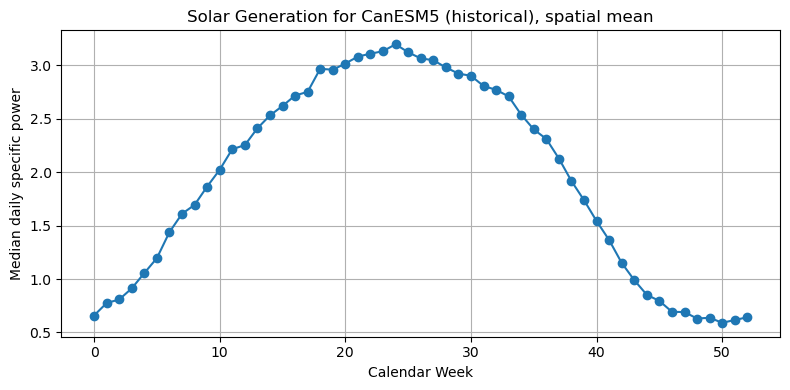

In [47]:
file="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CanESM5_1x1grid/historical/daily_mean_per_week.nc"
model="CanESM5"
period="historical"
ds=xr.open_dataset(file, engine="netcdf4")
p=ds['specific generation'].sel(y=41,x=2)
spatial_mean = ds['specific generation'].mean(dim=['y', 'x'])
plt.figure(figsize=(8, 4))
plt.plot(spatial_mean, marker='o', linestyle='-')
plt.xlabel("Calendar Week")
plt.ylabel("Median daily specific power")
plt.title(f"Solar Generation for {model} ({period}), spatial mean")
plt.grid(True)
plt.tight_layout()
plt.show()



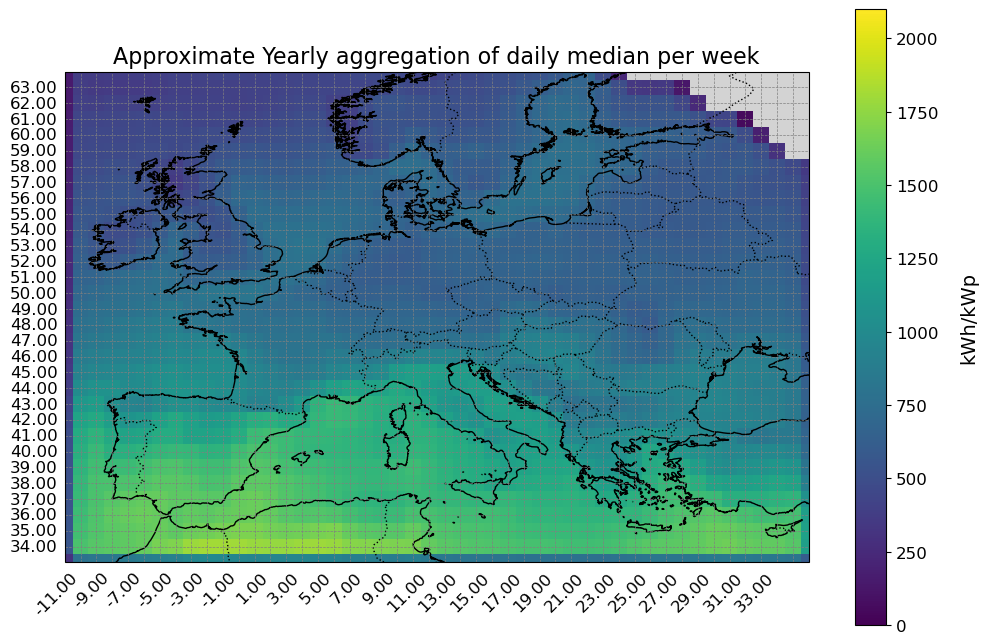

In [44]:
yearly_sum=ds['specific generation'].sum(dim='weekofyear')*7
from plots import map_plots
map_plots(yearly_sum, cmap='viridis', setnan=True, vmin=0, vmax=2100, title='Approximate Yearly aggregation of daily median per week', label='kWh/kWp')


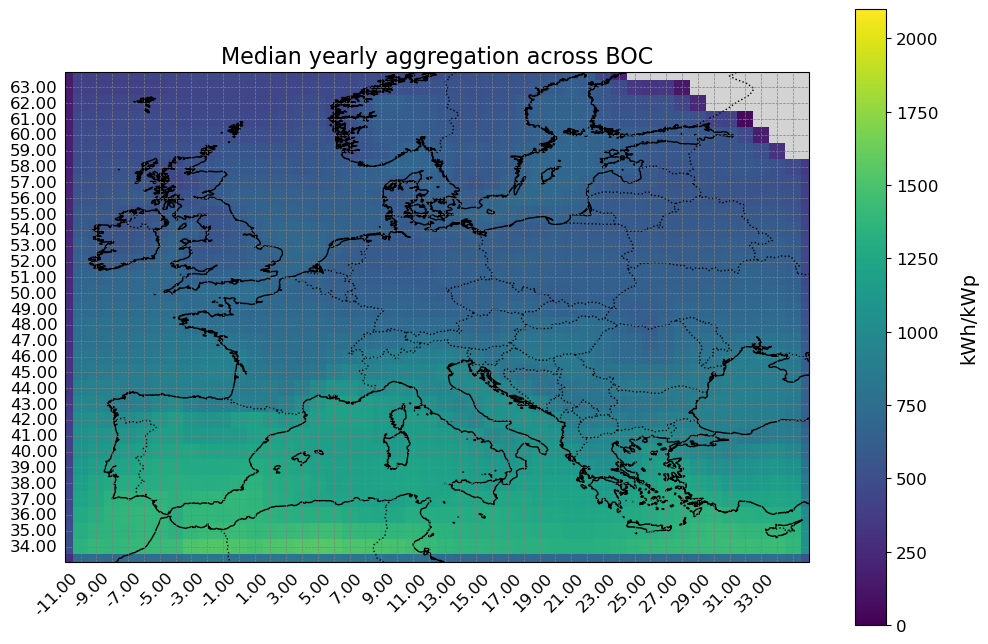

In [45]:
import xarray as xr
import os
import glob
import numpy as np
import re

# Define folder and pattern
folder = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CMCC-CM2-SR5_1x1grid/historical/"
pattern = os.path.join(folder, "aggregated_solar_power_*.nc")

# Get sorted list of matching files
file_list = [
    f for f in glob.glob(pattern)
    if re.search(r'aggregated_solar_power_\d{4}\.nc$', os.path.basename(f))
]

# Extract years from filenames (you may need to adjust this depending on your naming convention)
def extract_year(filename):
    return int(os.path.basename(filename).split('_')[-1].split('.')[0])  # assumes format: ..._YYYY.nc

# Load datasets and assign synthetic year dimension
maps = []
years = []

for fp in file_list:
    ds = xr.open_dataset(fp)
    da = ds['specific generation']
    
    year = extract_year(fp)
    da = da.expand_dims(year=[year])  # create a new 'year' dimension
    maps.append(da)
    years.append(year)

# Concatenate along the new year dimension
stacked = xr.concat(maps, dim='year')

# Compute median across years
median_map = stacked.median(dim='year')

# Plot
map_plots(median_map, cmap='viridis', setnan=True, vmin=0, vmax=2100,
          title='Median yearly aggregation across BOC', label='kWh/kWp')


In [ ]:
# Define folder and file pattern
folder = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/"
pattern = os.path.join(folder, "aggregated_solar_power_*.nc")
import glob
# Get sorted list of matching files
file_list = sorted(glob.glob(pattern))

# Load datasets one by one
datasets = []
for fp in file_list:
    ds = xr.open_dataset(fp)
    if 'time' not in ds:
        raise ValueError(f"'time' coordinate missing in {fp}")
    datasets.append(ds)

# Concatenate along time dimension
combined = xr.concat(datasets, dim='time')


# Assume the relevant variable is named 'solar_power' (change if different)
variable_name = 'solar generation'
# Compute mean across all days (implicitly across years)
mean_across_years = ds['specific generation'].median(dim='time')
map_plots(mean_across_years, cmap='viridis', setnan=True, vmin=0, vmax=2100, title='Median yearly aggregation accross BOC', label='kWh/kWp')


ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [ ]:

droughts_agg = {}
for period, info in periods.items():
    all_counts = []
    all_meandurs = []
    for model in models:
        base_dir = os.path.join(diri, f"{model}_1x1grid", info['subpath'])
        files = [os.path.join(base_dir, f"solar_power_{yr}.nc") for yr in info['years']]
        for yr in info['years']:
            year_file = os.path.join(base_dir, f"solar_power_{yr}.nc")
            if not os.path.isfile(year_file):
                continue
            daily = compute_daily_series(year_file, variable=variable_name)
            cnt, mdur = detect_droughts(daily, weekly_clim, min_run=2)
            all_counts.append(cnt)
            all_meandurs.append(mdur)
    # after looping all models and years for this period
    counts_stack = xr.concat(all_counts, dim='model_year', compat='override')
    mdurs_stack = xr.concat(all_meandurs, dim='model_year', compat='override')
    droughts_agg[period] = {
        'mean_event_count': counts_stack.mean(dim='model_year'),
        'mean_event_duration': mdurs_stack.mean(dim='model_year')
    }

# Results accessible as:
# droughts_agg['BOC']['mean_event_count']
# droughts_agg['BOC']['mean_event_duration']

/tmp/ipykernel_94926/3580825923.py:7: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds = xr.open_dataset(


ValueError: Cannot specify both coords='different' and compat='override'.